In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [2]:
import torch

X, y = mnist.data, mnist.target.astype(int)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

split = int(len(X) * 6 / 7)
train_X, test_X = torch.from_numpy(X[:split]).float().to(device), torch.from_numpy(X[split:]).float().to(device)
train_y, test_y = torch.from_numpy(y[:split]).long().to(device), torch.from_numpy(y[split:]).long().to(device)
train_X.shape, test_X.shape, train_y.shape, test_y.shape

(torch.Size([60000, 784]),
 torch.Size([10000, 784]),
 torch.Size([60000]),
 torch.Size([10000]))

In [4]:
import torch.nn as nn

class MulticlassSLP(nn.Module):
    def __init__(self, input_dim=784, num_classes=10):
        super().__init__()
        self.weight = nn.Parameter(torch.randn((input_dim, num_classes), device=device, requires_grad=True))
        self.bias = nn.Parameter(torch.randn(num_classes, device=device, requires_grad=True))
    
    def forward(self, X):
        return X @ self.weight + self.bias

In [35]:
criterion = nn.CrossEntropyLoss()
model = MulticlassSLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train, test = [], []
epoch = 150000000
best_loss = float('inf')
patience, wait = 2500, 0

for i in range(epoch):
    loss = criterion(model(train_X), train_y)
    model.train()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        train.append(loss.item())
        test.append(criterion(model(test_X), test_y).item())
    if loss.item() < best_loss:
        best_loss = loss.item()
    else:
        wait += 1
        if wait >= patience:
            break

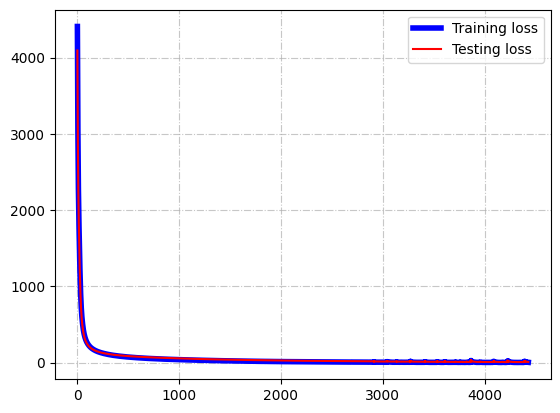

In [36]:
import matplotlib.pyplot as plt

linspace = torch.linspace(0, len(train) - 1, len(train))
plt.plot(linspace, train, linewidth=4, color='blue', label='Training loss')
plt.plot(linspace, test, color='red', label='Testing loss')
plt.grid(linestyle='-.', alpha=0.7)
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), '../inference/param/MNIST_multiclass_SLP.pth')

In [46]:
del model
del optimizer
del criterion

del train_X, train_y, test_X, test_y

torch.cuda.empty_cache()

NameError: name 'model' is not defined